# Basic Marvel Network Analysis
By Jack Hart

## Initial Data Cleaning and Processing

### Import packages

In [16]:
"""
@author: Jack Hart
"""
import numpy as np
import pandas as pd
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
import networkx as nx
import itertools
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from networkx.algorithms import community
from plotly.offline import init_notebook_mode, iplot
import plotly.tools as tls
from IPython.display import HTML
import warnings
warnings.filterwarnings('ignore')

init_notebook_mode(connected=True)

### Import Data

In [2]:
character_details = pd.read_csv('characters.csv', encoding='latin-1')

#node/comics data
comics = pd.read_csv('comics.csv', encoding='latin-1')

#edge data
edges_CharacterComic = pd.read_csv('charactersToComics.csv', encoding='latin-1')

### Group Comics by Issue
There are multiple issues for many comics.  To create a more interesting network, I'll group comics of the same issue together.

In [3]:
comics['cleanTitles'] = comics.title.str.split('#', expand = True)[0]
      
temp = comics.groupby(['cleanTitles']).size().reset_index()
temp = temp.rename(columns={0: "count"})
comics_unique = temp

### Add Names to Edge List
The edge dataframe only has the ids for characters and comics.  

In [4]:
#create functions for apply
def findComic(EdgeID, comicList):
    return(comics['cleanTitles'][comicList.index(EdgeID)])

def findCharacter(EdgeID, characterList):
    return(character_details['name'][characterList.index(EdgeID)])

#create names in the edges dataframe
listofComics = list(comics['comicID'])
edges_CharacterComic['comicName'] = edges_CharacterComic['comicID'].apply(lambda x: findComic(x,listofComics))

listofCharacters = list(character_details['characterID'])
edges_CharacterComic['characterName'] = edges_CharacterComic['characterID'].apply(lambda x: findCharacter(x,listofCharacters))

### Create List of Edges

In [5]:
#create edges list
Edges=[(edges_CharacterComic['characterName'][k], edges_CharacterComic['comicName'][k]) for k in range(len(edges_CharacterComic))]

#Remove duplicate edges created by "cleaning" comics to remove repeats
Edges = list(set(Edges))

### Create Attribute Values for Nodes
This code creates a list attribute values that distingish character nodes from comic nodes.

In [6]:
#list of labels and group type for nodes
labels=[]
group=dict()

labels.extend(list(set(comics_unique['cleanTitles'])))
for node in list(set(comics_unique['cleanTitles'])):
    count = int(comics_unique[comics_unique['cleanTitles'] == node]['count'])
    group[str(node)] = {'type': 'comic', 'count': count}

labels.extend(list(set(character_details['name'])))
for node in list(set(character_details['name'])):
    group[str(node)] = {'type': 'character'}

## Character to Comic Network Creation, Analysis, and Plots

### Create Network with Networkx

In [7]:
#create graph
G=nx.Graph()

#add nodes to graph
G.add_nodes_from(labels)

#add in node attributes
nx.set_node_attributes(G, group)

#add edges to graph
G.add_edges_from(Edges)

This is too large to be efficiently computed with the spring_layout and kamada_kawai_layout functions. Remove nodes with low number of connections (and their edges).

In [8]:
#keep nodes with >10 degrees
keep = [node for node,degree in G.degree() if degree > 10]
keep = dict((k, G.node(data=True)[k]) for k in tuple(keep))

#significantly decreased number of nodes
print(G.number_of_nodes())
print(len(keep))

#create new (smaller) graph
f = nx.Graph()                                                                                          
fedges = filter(lambda x: G.degree()[x[0]] > 10 and G.degree()[x[1]] > 10, G.edges())
f.add_nodes_from(keep)
f.add_edges_from(fedges)
nx.set_node_attributes(f, keep)

#reduced the number of edges
print(G.number_of_edges())
print(f.number_of_edges())

10193
952
23402
11473


Next, set the layouts for the 3-D and 2-D graphs

In [20]:
#Set the 3-d layout type
pos = nx.spring_layout(f, dim = 3)

#Set the 2-d layout type
pos_2 = nx.kamada_kawai_layout(f, dim = 2)

### Some Network Analysis
First, look at the density of the graph.  The graph isn't very dense at all.  This makes sense, given character nodes can only be connected to comic nodes, and vice versa

In [9]:
#aveage density 
print(nx.density(G))

0.00045052773465830044


average clustering -- this will be 0 because all neighbors of a node will not be connected due to the nature of this graph

In [10]:
print(nx.average_clustering(G))
#Therefore, connot use closeness centrality for determining important nodes

0.0


#### Degree Analysis

In [9]:
#Create list of comic and character node names
comicNodes = [x for x,y in f.nodes(data=True) if y['type'] == 'comic']
characterNodes = [x for x,y in f.nodes(data=True) if y['type'] == 'character']

#Create lists of comic and character node degrees
comicdegrees = []
comicOrder = []
characterdegrees = []
characterOrder = []
for node, degree in G.degree():
    if node in comicNodes:
        comicdegrees.append(degree)
        comicOrder.append(node)
        
    else:
        characterdegrees.append(degree)
        characterOrder.append(node)
        
#Count the frequency of degrrees and put them into dataframes
comicCounts = Counter(comicdegrees)
comicCounts = pd.DataFrame(list(dict(comicCounts).items()), columns=['degree', 'count']).sort_values(by=['degree'])

characterCounts = Counter(characterdegrees)
characterCounts = pd.DataFrame(list(dict(characterCounts).items()), columns=['degree', 'count']).sort_values(by=['degree'])

Plot the degree frequencies of comic nodes and character nodes.  Characters have a much larger range of connections.  There is also a larger frequency of characters with lower degrees, compared to comics.  Can be viewed here: [Degree Line Plot for Character to Comic Network](https://plot.ly/~jackhart/113/marvel-character-to-comic-network-degrees/#/)

In [17]:
#Plot degrees
trace_comic_degree = go.Scatter(
    x = list(comicCounts['degree']),
    y = list(comicCounts['count']),
    mode = 'lines+markers',
    name = 'Comics'
)

trace_character_degree = go.Scatter(
    x = list(characterCounts['degree']),
    y = list(characterCounts['count']),
    mode = 'lines+markers',
    name = 'Characters'
)

layout=go.Layout(
    title="<b>Marvel Character To Comic Network Degrees",
    titlefont=dict(size=16),
    showlegend=True,
    hovermode='closest',
    xaxis = dict(title = 'Degree (# of connections to node)', range=[0, 150]),
    yaxis = dict(title = 'Count (the amount of nodes with a certain # of connections)', range=[0, 100]) )

fig = go.Figure(data=[trace_comic_degree, trace_character_degree], layout = layout)

#plot offline
#plotly.offline.plot(fig, filename = "DegreeLinePlot.html")

#iplot(fig, filename = "DegreeLinePlot.html")
HTML(tls.get_embed('https://plot.ly/~jackhart/113'))


The average degree of connectivity is the average number of connections a particular nodes' neighbors have.  The following plot compares a given nodes degree, to the average degree of its neighbors.  Can be viewed here: [Conectivity Line Plot for Character to Comic Network](https://plot.ly/~jackhart/115/marvel-character-to-comic-network-average-degree-of-neighbors-for-nodes-of-given/#/).

There's a pretty significant difference in connectivity between nodes with a high degrees versus those with lower degrees.  Nodes with few connections tend to be connected to nodes with a high number of connections.  I'm assuming this can be explained by the principle behind the [friendship paradox](https://en.wikipedia.org/wiki/Friendship_paradox).

In [18]:
#average degree conections of neighbors for a node with given # of connections.
conectivity = pd.DataFrame(list(nx.average_degree_connectivity(G).items()), columns=['degree', 'averagedegree']).sort_values(by=['degree'])

#plot average degree conections
trace_degree = go.Scatter(
    x = list(conectivity['degree']),
    y = list(conectivity['averagedegree']),
    mode = 'lines+markers',
    name = 'Average Degrees'
)

layout=go.Layout(
    title="<b>Marvel Character To Comic Network: Average Degree of Neighbors for Nodes of Given Degree",
    titlefont=dict(size=16),
    showlegend=False,
    hovermode='closest',
    xaxis = dict(title = 'Node Degree (# of connections to node)', range=[0, 200]),
    yaxis = dict(title = "Average Degree of Neighbors (aveage # of connections for a nodes neighbors)", range=[0, 250]) )

fig = go.Figure(data=[trace_degree], layout = layout)

#plot offline
#plotly.offline.plot(fig, filename = "ConectivityLinePlot.html")
#iplot(fig, filename='ConectivityLinePlot')
HTML(tls.get_embed('https://plot.ly/~jackhart/115'))


Next, compare the comic and character nodes with the highest degree.

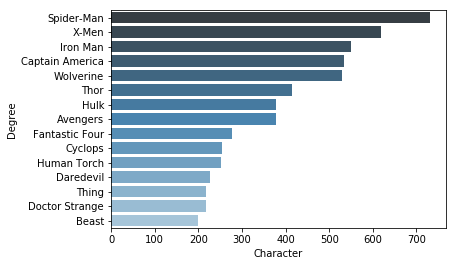

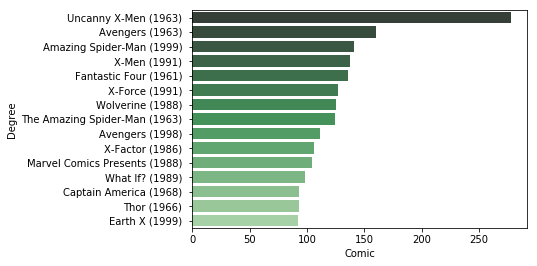

In [12]:
#Find comics and character nodes with greatest number of degrees
comicsByDegree = pd.DataFrame({'comic': comicOrder, 'degree': comicdegrees}).sort_values(by=['degree'], ascending = False)
charactersByDegree = pd.DataFrame({'character': characterOrder, 'degree': characterdegrees}).sort_values(by=['degree'], ascending = False)
comicsByDegreeHead = comicsByDegree.head(15)
charactersByDegreeHead = charactersByDegree.head(15)

ax = sns.barplot(x=charactersByDegreeHead.degree, y=charactersByDegreeHead.character,
                 palette="Blues_d")
ax.set(xlabel='Character', ylabel='Degree')
plt.show()

ax2 = sns.barplot(x=comicsByDegreeHead.degree, y=comicsByDegreeHead.comic,
                 palette="Greens_d")
ax2.set(xlabel='Comic', ylabel='Degree')
plt.show()

### Plot 3-D Character to Comic Network
First, create the edge trace.

In [21]:
#create the edges
edge_trace = go.Scatter3d(
    x=[],
    y=[],
    z=[],
    line=dict(width=1,color='#888'),
    hoverinfo='none',
    mode='lines')


#apply functions for adding edge positions
def returnxPositions(edge, formats):
    return(tuple([formats[edge[0]][0],formats[edge[1]][0], None]))

def returnyPositions(edge, formats):
    return(tuple([formats[edge[0]][1],formats[edge[1]][1], None]))

def returnzPositions(edge, formats):
    return(tuple([formats[edge[0]][2],formats[edge[1]][2], None]))


#add edge postions to trace
edge_trace['x'] = tuple(itertools.chain(*pd.Series(f.edges()).apply(lambda x: returnxPositions(x,pos))))
edge_trace['y'] = tuple(itertools.chain(*pd.Series(f.edges()).apply(lambda x: returnyPositions(x,pos))))
edge_trace['z'] = tuple(itertools.chain(*pd.Series(f.edges()).apply(lambda x: returnzPositions(x,pos))))

Next, create the node traces for comics and characters.

In [22]:
#create the nodes for comics (with the color based on # of connections)
node_trace_comic = go.Scatter3d(
    x=[],
    y=[],
    z=[],
    text=[],
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale='Greens',
        reversescale=True,
        color=[],
        size=20,
        colorbar=dict(
            thickness=10,
            title='Node Connections for Comics',
            xanchor='left',
            titleside='right'
        ),
        line=dict(width=2))    
        )

for node in comicNodes:
    x, y, z = pos[node]
    node_trace_comic['x'] += tuple([x])
    node_trace_comic['y'] += tuple([y])
    node_trace_comic['z'] += tuple([z])
    
for node, adjacencies in f.adjacency():
    if(node in comicNodes):
        node_trace_comic['marker']['color']+=tuple([len(adjacencies)])
        node_info = ('Comic: {comic}<br>'+ '# of Issues: {issues}<br>'+
         '# of connections: {connections}<br>').format(comic = str(node),
                                                       issues = keep[node]['count'],
                                                       connections = str(len(adjacencies)))
        node_trace_comic['text']+=tuple([node_info])



#create the nodes for characters (with the color based on # of connections)
node_trace_character = go.Scatter3d(
    x=[],
    y=[],
    z=[],
    text=[],
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale='Blues',
        reversescale=True,
        color=[],
        size=20,
        colorbar=dict(
            thickness=10,
            title='Node Connections for Characters',
            xanchor='right',
            titleside='right'
        ),
        line=dict(width=2))    
        )


for node in characterNodes:
    x, y, z = pos[node]
    node_trace_character['x'] += tuple([x])
    node_trace_character['y'] += tuple([y])
    node_trace_character['z'] += tuple([z])

for node, adjacencies in f.adjacency():
    if(node in characterNodes):
        node_trace_character['marker']['color']+=tuple([len(adjacencies)])
        node_info = ('Character: {character}<br>'+ '# of connections: {connections}<br>').format(
                     character = str(node),
                     connections = str(len(adjacencies)))
        node_trace_character['text']+=tuple([node_info])
        
        #node_info = str(node) + ': # of connections = '+str(len(adjacencies))
        #node_trace_character['text']+=tuple([node_info])
    


Finally, create the layout and plot. Network can be viewed here: [3-D Character to Comic Network](https://plot.ly/~jackhart/129/marvel-network-characters-relationships-to-comics/#/)

In [23]:
#create the layout
layout=go.Layout(
    title="<b>Marvel Network: Characters' Relationships to Comics",
    titlefont=dict(size=16),
    showlegend=False,
    hovermode='closest',
    margin=dict(b=20,l=5,r=5,t=40),
    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
    )


#combine
fig = go.Figure(data=[edge_trace, node_trace_character, node_trace_comic], layout = layout)

#plot offline
#plotly.offline.plot(fig, filename = "SuperHeroComicNetwork.html")
#iplot(fig, filename='SuperHeroComicNetwork')
HTML(tls.get_embed('https://plot.ly/~jackhart/129/'))

### Plot 2-D Character to Comic Network
Creation of the traces and layout follows a similar process.   View the netowrk here: [2-D Character to Comic Network](https://plot.ly/~jackhart/131/marvel-network-characters-relationships-to-comics/#/).

In [24]:
#create the edges
edge_trace2 = go.Scatter(
    x=[],
    y=[],
    line=dict(width=.3,color='#888'),
    hoverinfo='none',
    mode='lines')

#add edge postions to trace
edge_trace2['x'] = tuple(itertools.chain(*pd.Series(f.edges()).apply(lambda x: returnxPositions(x,pos_2))))
edge_trace2['y'] = tuple(itertools.chain(*pd.Series(f.edges()).apply(lambda x: returnyPositions(x,pos_2))))

#create the nodes for comics (with the color based on # of connections)
node_trace_comic_2 = go.Scatter(
    x=[],
    y=[],
    text=[],
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale='Greens',
        reversescale=True,
        color=[],
        size=20,
        colorbar=dict(
            thickness=10,
            title='Node Connections for Comics',
            xanchor='left',
            titleside='right'
        ),
        line=dict(width=2))    
        )

for node in comicNodes:
    x, y = pos_2[node]
    node_trace_comic_2['x'] += tuple([x])
    node_trace_comic_2['y'] += tuple([y])
    
for node, adjacencies in f.adjacency():
    if(node in comicNodes):
        node_trace_comic_2['marker']['color']+=tuple([len(adjacencies)])
        node_info = ('Comic: {comic}<br>'+ '# of Issues: {issues}<br>'+
         '# of connections: {connections}<br>').format(comic = str(node),
                                                       issues = keep[node]['count'],
                                                       connections = str(len(adjacencies)))
        node_trace_comic_2['text']+=tuple([node_info])


#create the nodes for characters (with the color based on # of connections)
node_trace_character_2 = go.Scatter(
    x=[],
    y=[],
    text=[],
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale='Blues',
        reversescale=True,
        color=[],
        size=20,
        colorbar=dict(
            thickness=10,
            title='Node Connections for Characters',
            xanchor='right',
            titleside='right'
        ),
        line=dict(width=2))    
        )

for node in characterNodes:
    x, y = pos_2[node]
    node_trace_character_2['x'] += tuple([x])
    node_trace_character_2['y'] += tuple([y])

for node, adjacencies in f.adjacency():
    if(node in characterNodes):
        node_trace_character_2['marker']['color']+=tuple([len(adjacencies)])
        node_info = ('Character: {character}<br>'+ '# of connections: {connections}<br>').format(
                     character = str(node),
                     connections = str(len(adjacencies)))
        node_trace_character_2['text']+=tuple([node_info])


#create the layout
layout=go.Layout(
    title="<b>Marvel Network: Characters' Relationships to Comics",
    titlefont=dict(size=16),
    showlegend=False,
    hovermode='closest',
    margin=dict(b=20,l=5,r=5,t=40),
    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    annotations=[
        dict(
        showarrow=False,
        text="Original network had 10193 nodes and 23402 edges. <br> For simplicity, this is a network contains only the nodes of the original network with greater than 10 connections. ",
        xref='paper',
        yref='paper',
        x=0,
        y=0.05,
        xanchor='left',
        yanchor='bottom',
        font=dict(
        size=14
        ))]
    )


#combine
fig2 = go.Figure(data=[edge_trace2, node_trace_character_2, node_trace_comic_2], layout = layout)

#plot offline
#plotly.offline.plot(fig2, filename = "SuperHeroComicNetwork2D.html")

#iplot(fig2, filename='SuperHeroComicNetwork2D')
HTML(tls.get_embed('https://plot.ly/~jackhart/131/'))

## Character to Character Network Creation, Analysis, and Plots

### Process Data for Network
The data is formatted to show the relationship between comics and characters.  This code sorts through all of the edges to create a new network that removes the comics and shows the direct realtionships between characters.

In [25]:
#create a sorted numpy array
numpyEdges = edges_CharacterComic.sort_values(by=['comicID']).values

#sort into separte arrays by comic connection ~45 seconds
x = numpyEdges[:,[2,3]]
y = [x[x[:,0]==k] for k in np.unique(x[:,0])]

#create a list of lists that have combinations for each comic
lists = [list(itertools.combinations(y[x][:,1],2)) for x in range(len(y))]

#put all into 1 list
Allcombinations = [item for sublist in lists for item in sublist]

#get only unique combinations
combinations = list(set(tuple(sorted(p)) for p in Allcombinations)) 

#remove edges with same nodes
combinations = [ (a,b) for a,b in combinations if a != b] 

#create a pandas dataframe
hero_edges = pd.DataFrame(combinations, columns=['char1', 'char2'])

### Create Network with Networkx
Create the network object and set the layouts

In [26]:
#Create list of character (node) names
labels2 = list(set(character_details['name']))

#create graph
G2=nx.Graph()

#add nodes to graph
G2.add_nodes_from(labels2)

#add edges to graph
G2.add_edges_from(combinations)

I was able to generate the entire graph in previous versions (view previous commits).  However, the network is too large to not lag in plotly and the notebook.   Therefore, the actual network will be created based on a subset that contains the nodes with the most connections.

In [27]:
#keep nodes with >10 degrees
keep2 = [node for node,degree in G2.degree() if degree > 50]
keep2 = dict((k, G2.node(data=True)[k]) for k in tuple(keep2))

#significantly decreased number of nodes
print(G2.number_of_nodes())
print(len(keep2))

#create new (smaller) graph
f2 = nx.Graph()                                                                                          
fedges = filter(lambda x: G.degree()[x[0]] > 50 and G2.degree()[x[1]] > 50, G2.edges())
f2.add_nodes_from(keep2)
f2.add_edges_from(fedges)
nx.set_node_attributes(f2, keep2)

#reduced the number of edges
print(G2.number_of_edges())
print(f2.number_of_edges())

1169
865
119189
25838


In [18]:
#Remove nodes with no connections
f2.remove_nodes_from(list(nx.isolates(f2)))

### Create Network layout

In [28]:
#Set the 3-d layout type
pos_3 = nx.spring_layout(f2, dim = 3)

#Set the 2-d layout type 
pos_4 = nx.kamada_kawai_layout(f2, dim = 2)

### Plot 3-D Character to Character Network
The network can be viewed here: [3-D Character to Character Network](https://plot.ly/~jackhart/133).

In [29]:
#create the edges
edge_trace_4 = go.Scatter3d(
    x=[],
    y=[],
    z=[],
    line=dict(width=1,color='#888'),
    hoverinfo='none',
    mode='lines')

#add edge postions to trace
edge_trace_4['x'] = tuple(itertools.chain(*pd.Series(f2.edges()).apply(lambda x: returnxPositions(x,pos_3))))
edge_trace_4['y'] = tuple(itertools.chain(*pd.Series(f2.edges()).apply(lambda x: returnyPositions(x,pos_3))))
edge_trace_4['z'] = tuple(itertools.chain(*pd.Series(f2.edges()).apply(lambda x: returnzPositions(x,pos_3))))


#create the nodes (with the color based on # of connections)
node_trace_4 = go.Scatter3d(
    x=[],
    y=[],
    z=[],
    text=[],
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale='Blues',
        reversescale=True,
        color=[],
        size=20,
        colorbar=dict(
            thickness=10,
            title='Node Connections',
            xanchor='right',
            titleside='right'
        ),
        line=dict(width=2))    
        )

characterNodes = [x for x,y in f2.nodes(data=True)]
for node in characterNodes:
    x, y, z = pos_3[node]
    node_trace_4['x'] += tuple([x])
    node_trace_4['y'] += tuple([y])
    node_trace_4['z'] += tuple([z])

for node, adjacencies in f2.adjacency():
    if(node in characterNodes):
        node_trace_4['marker']['color']+=tuple([len(adjacencies)])
        node_info = ('Character: {character}<br>'+ '# of connections: {connections}<br>').format(
                     character = str(node),
                     connections = str(len(adjacencies)))
        node_trace_4['text']+=tuple([node_info])

#create the layout
layout=go.Layout(
    title="<b>Marvel Network: Hero Relationships",
    titlefont=dict(size=16),
    showlegend=False,
    hovermode='closest',
    margin=dict(b=20,l=5,r=5,t=40),
    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
    )

#combine
fig = go.Figure(data=[edge_trace_4, node_trace_4], layout = layout)

#plot offline
#plotly.offline.plot(fig, filename = "SuperHeroNetwork3D.html")

#iplot(fig, filename='SuperHeroNetwork3D')
HTML(tls.get_embed('https://plot.ly/~jackhart/133/'))

### Plot 2-D Character to Character Network
The network can be viewed here: [2-D Character to Character Network](https://plot.ly/~jackhart/135).

In [34]:
#create the edges
edge_trace3 = go.Scatter(
    x=[],
    y=[],
    line=dict(width=.3,color='#888'),
    hoverinfo='none',
    mode='lines')

#add edge postions to trace
edge_trace3['x'] = tuple(itertools.chain(*pd.Series(f2.edges()).apply(lambda x: returnxPositions(x, pos_4))))
edge_trace3['y'] = tuple(itertools.chain(*pd.Series(f2.edges()).apply(lambda x: returnyPositions(x, pos_4))))


#create the nodes (with the color based on # of connections)
node_trace_3 = go.Scatter(
    x=[],
    y=[],
    text=[],
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale='Blues',
        reversescale=True,
        color=[],
        size=20,
        colorbar=dict(
            thickness=10,
            title='Node Connections',
            xanchor='right',
            titleside='right'
        ),
        line=dict(width=2))    
        )

characterNodes = [x for x,y in f2.nodes(data=True)]

for node in characterNodes:
    x, y = pos_4[node]
    node_trace_3['x'] += tuple([x])
    node_trace_3['y'] += tuple([y])

for node, adjacencies in f2.adjacency():
        node_trace_3['marker']['color']+=tuple([len(adjacencies)])
        node_info = ('Character: {character}<br>'+ '# of connections: {connections}<br>').format(
                     character = str(node),
                     connections = str(len(adjacencies)))
        node_trace_3['text']+=tuple([node_info])


#create the layout
layout=go.Layout(
    title='<b>Marvel Network: Hero Relationships',
    titlefont=dict(size=16),
    showlegend=False,
    hovermode='closest',
    margin=dict(b=20,l=5,r=5,t=40),
    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    annotations=[
        dict(
        showarrow=False,
        xref='paper',
        yref='paper',
        x=0,
        y=0.05,
        xanchor='left',
        yanchor='bottom',
        font=dict(
        size=14
        ))]
    )


#combine
fig3 = go.Figure(data=[edge_trace3, node_trace_3], layout = layout)

#plot offline
#plotly.offline.plot(fig3, filename = "SuperHeroNetwork2D.html")

#iplot(fig3, filename='SuperHeroNetwork2D')
HTML(tls.get_embed('https://plot.ly/~jackhart/135/'))

### Network Analysis
The density of this network is much higher than the previous.

In [ ]:
#aveage density 
print(nx.density(G2))

The clustering coeficient is relativly high, about 0.77.  This means nodes' neighbors are highly connected to one another.

In [ ]:
#average clustering -- 0.77
print(nx.average_clustering(G2))

The following plot compares the average degree conectivity for nodes by their degree.  This is similar to the connectivity line plot made for the comic to character network.  The plot can be viewed here: [Character to Character Average Connectivity Line Plot](https://plot.ly/~jackhart/121).

In [35]:
conectivity2 = pd.DataFrame(list(nx.average_degree_connectivity(G2).items()), columns=['degree', 'averagedegree']).sort_values(by=['degree'])

#plot average degree conections
trace_degree_2 = go.Scatter(
    x = list(conectivity2['degree']),
    y = list(conectivity2['averagedegree']),
    mode = 'lines+markers',
    name = 'Average Degrees'
)

layout=go.Layout(
    title="<b>Marvel Character Network: Average Degree of Neighbors for Nodes of Given Degree",
    titlefont=dict(size=16),
    showlegend=False,
    hovermode='closest',
    xaxis = dict(title = 'Node Degree (# of connections to node)', range=[0, 900]),
    yaxis = dict(title = "Average Degree of Neighbors (aveage # of connections for a nodes neighbors)", range=[0, 550]) )

fig = go.Figure(data=[trace_degree_2], layout = layout)

#plot offline
#plotly.offline.plot(fig, filename = "ConectivityLinePlotCharacter.html")
#iplot(fig, filename='ConectivityLinePlotCharacter')
HTML(tls.get_embed('https://plot.ly/~jackhart/121/'))

The following plots look at nodes with the greatest degree as well as the highest betweenness.  Both a measures that can be used to determine how *important* a particular node is for a network.

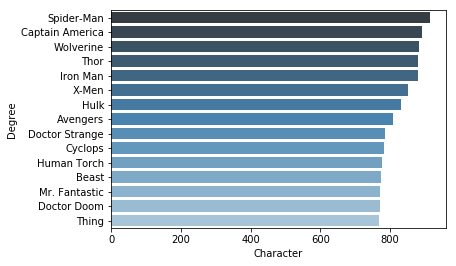

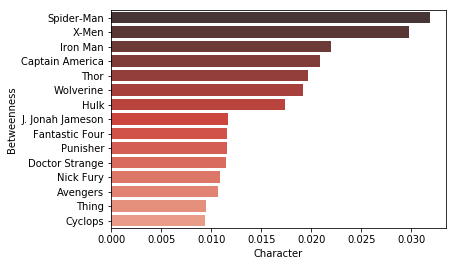

In [36]:
#Find character nodes with greatest number of degrees
characterdegrees2 = []
characterOrder2 = []
for node, degree in G2.degree():
    characterdegrees2.append(degree)
    characterOrder2.append(node)

charactersByDegree = pd.DataFrame({'character': characterOrder2, 'degree': characterdegrees2}).sort_values(by=['degree'], ascending = False)
charactersByDegreeHead = charactersByDegree.head(15)

ax = sns.barplot(x=charactersByDegreeHead.degree, y=charactersByDegreeHead.character,
                 palette="Blues_d")
ax.set(xlabel='Character', ylabel='Degree')
plt.show()


# Betweenness centrality
bet_cen = nx.betweenness_centrality(G2)

betweeness_df = pd.DataFrame(list(bet_cen.items()), columns=['character', 'betweeness']).sort_values(by=['betweeness'], ascending = False)
betweeness_dfHead = betweeness_df.head(15)

ax2 = sns.barplot(x=betweeness_dfHead.betweeness, y=betweeness_dfHead.character,
                 palette="Reds_d")
ax2.set(xlabel='Character', ylabel='Betweenness')
plt.show()

## Subgraphs of the Character to Character Network
The following analysis looks for possible clusters in the character network.  The Kernighan–Lin algorithm algorithm is used to break the network into two points.  According the the function's [documention](https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.kernighan_lin.kernighan_lin_bisection.html#networkx.algorithms.community.kernighan_lin.kernighan_lin_bisection), the algorithm "...paritions a network into two sets by iteratively swapping pairs of nodes to reduce the edge cut between the two sets."

### Create the partioned Network
Partition the network using the algorithm and create a new network object that contains both dijoint networks.  This code additonally creates the formatting for the network.

In [37]:
sub_graphs = list(community.kernighan_lin_bisection(f2))

#list of nodes
sub1Nodes = list(sub_graphs[0])
sub2Nodes = list(sub_graphs[1])

#list of edges
sub1Edges = [ (a,b) for a,b in combinations if (a in sub1Nodes) and (b in sub1Nodes) ] 
sub2Edges = [ (a,b) for a,b in combinations if (a in sub2Nodes) and (b in sub2Nodes) ] 

#combine edge and node list together, because I will plot on one graph
totalEdges = sub1Edges + sub2Edges
totalNodes = sub1Nodes + sub2Nodes

#This graph is technically two graphs, you can see this by the decrease in the number of edges
# compared to the origonal
print(len(totalEdges))
print(len(combinations))


#Create networkx graphs for each subgraph
#First subgraph
G3=nx.Graph()

#add nodes to graph
G3.add_nodes_from(totalNodes)

#add edges to graph
G3.add_edges_from(totalEdges)

#Set the 2-d layout type 
#************************** ~5 minutes on my computer
pos_5 = nx.spring_layout(G3, dim = 2)

60890
119189


### Create 2-D Partitioned Character to Character Network
The network can be viewed here: [Character to Character Partitioned Network](https://plot.ly/~jackhart/125).

In [38]:
#create the edges
edge_trace5 = go.Scatter(
    x=[],
    y=[],
    line=dict(width=.3,color='#888'),
    hoverinfo='none',
    mode='lines')

#add edge postions to trace
edge_trace5['x'] = tuple(itertools.chain(*pd.Series(G3.edges()).apply(lambda x: returnxPositions(x, pos_5))))
edge_trace5['y'] = tuple(itertools.chain(*pd.Series(G3.edges()).apply(lambda x: returnyPositions(x, pos_5))))


#create the nodes (with the color based on # of connections)
node_trace_5 = go.Scatter(
    x=[],
    y=[],
    text=[],
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale='Blues',
        reversescale=True,
        color=[],
        size=20,
        colorbar=dict(
            thickness=10,
            title='Node Connections',
            xanchor='right',
            titleside='right'
        ),
        line=dict(width=2))    
        )

characterNodes = [x for x,y in G3.nodes(data=True)]
for node in characterNodes:
    x, y = pos_5[node]
    node_trace_5['x'] += tuple([x])
    node_trace_5['y'] += tuple([y])

for node, adjacencies in G3.adjacency():
        node_trace_5['marker']['color']+=tuple([len(adjacencies)])
        node_info = ('Character: {character}<br>'+ '# of connections: {connections}<br>').format(
                     character = str(node),
                     connections = str(len(adjacencies)))
        node_trace_5['text']+=tuple([node_info])


#create the layout
layout=go.Layout(
    title='<b>Marvel Sub-Networks: Hero Relationships',
    titlefont=dict(size=16),
    showlegend=False,
    hovermode='closest',
    margin=dict(b=20,l=5,r=5,t=40),
    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    annotations=[
        dict(
        showarrow=False,
        xref='paper',
        yref='paper',
        x=0,
        y=0.05,
        xanchor='left',
        yanchor='bottom',
        font=dict(
        size=14
        ))]
    )


#combine
fig5 = go.Figure(data=[edge_trace5, node_trace_5], layout = layout)

The following plot contains the partitioned networks.  One network is much less dense than the other.  This indicates some interesting realtionships between certain characters in the dense network.  

In [39]:
#plot offline
#plotly.offline.plot(fig5, filename = "SuperHeroSubNetworks2D.html")
#iplot(fig5, filename='SuperHeroSubNetworks2D')
HTML(tls.get_embed('https://plot.ly/~jackhart/125/'))